In [411]:
import numpy as np
import dwave.inspector
from dwave.system import DWaveSampler
import pickle
import pandas as pd
from pathlib import Path  
from datetime import datetime
import matplotlib.pyplot as plt
import os
import dimod
import networkx as nx
import dwave_networkx as dnx

import warnings
warnings.filterwarnings('ignore')

In [2]:

# Use a D-Wave system as the sampler
f = open("../token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=f.read())

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage2_prototype1.1 was selected.


In [3]:
#get the couplers and nodes available in the qpu
couplers_avail = np.array(sampler.edgelist)
nodes_avail = np.array(sampler.nodelist)

target_graph = nx.Graph()
target_graph.add_nodes_from(nodes_avail)
target_graph.add_edges_from(couplers_avail)

# random triangulation

In [4]:
from shapely.geometry import Point, Polygon
from libpysal import weights, examples
from libpysal.cg import voronoi_frames
import geopandas as gpd


def Random_Points_in_Bounds(polygon, number):   
    minx, miny, maxx, maxy = polygon.bounds
    x = np.random.uniform( minx, maxx, number )
    y = np.random.uniform( miny, maxy, number )
    return x, y


# polygon = Polygon([[0,0],[0,2],[1.5,1],[0.5,-0.5],[0,0]])
#a square
polygon = Polygon([[0,0],[0,2],[2,2],[2,0],[0,0]])
gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[polygon])

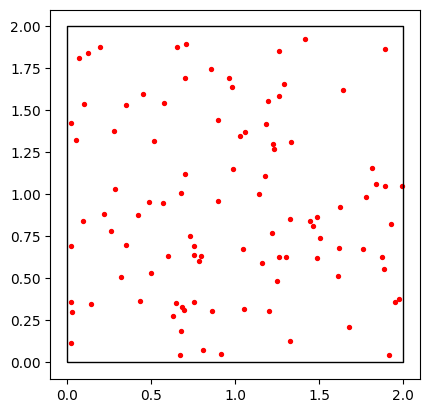

In [181]:
#random points in box
x,y = Random_Points_in_Bounds(polygon, 100)
df = pd.DataFrame()
df['points'] = list(zip(x,y))
df['points'] = df['points'].apply(Point)
gdf_points = gpd.GeoDataFrame(df, geometry='points')
# gdf_points = gpd.GeoDataFrame(df, geometry=GeoSeries)

#join and add to frame
Sjoin = gpd.tools.sjoin(gdf_points, gdf_poly, predicate="within", how='left')

# Keep points in "myPoly"
pnts_in_poly = gdf_points[Sjoin.index_right=='myPoly']

# Plot result
import matplotlib.pyplot as plt
base = gdf_poly.boundary.plot(linewidth=1, edgecolor="black")
pnts_in_poly.plot(ax=base, linewidth=1, color="red", markersize=8)
plt.show()

/home/vdrouint/packages/anaconda3/lib/python3.8/site-packages/libpysal/cg/voronoi.py:173: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  region_df["geometry"] = [Polygon(vertices[region]) for region in regions]
/home/vdrouint/packages/anaconda3/lib/python3.8/site-packages/libpysal/cg/voronoi.py:176: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoData

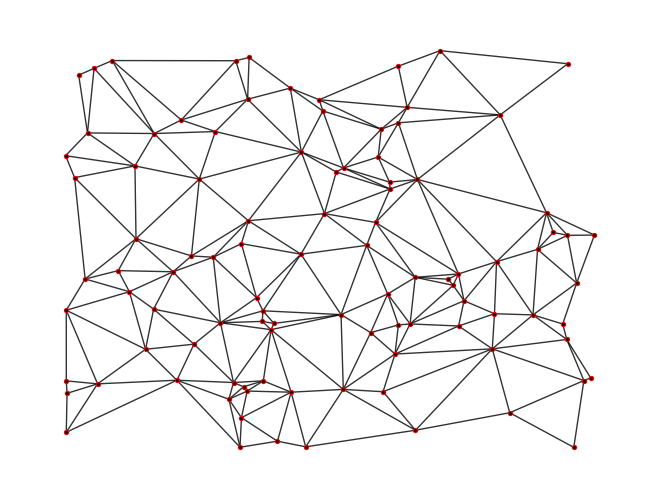

In [182]:
#pôint coordinates
coordinates = np.column_stack((gdf_points.points.x, gdf_points.points.y))

#voronoi boxes
cells, generators = voronoi_frames(coordinates, clip="convex hull")

#construct delaunay triangulation from the voronoi boxes
delaunay = weights.Rook.from_dataframe(cells)

# Once the graph is built, we can convert the graphs to networkx objects using the
# relevant method.
delaunay_graph = delaunay.to_networkx()

# To plot with networkx, we need to merge the nodes back to
# their positions in order to plot in networkx
positions = dict(zip(delaunay_graph.nodes, coordinates))

# Now, we can plot with a nice basemap.
# ax = cells.plot(facecolor="lightblue", alpha=0.50, edgecolor="cornsilk", linewidth=2)
# ax.axis("off")
nx.draw(
    delaunay_graph,
    positions,
    node_size=2,
    node_color="k",
    edge_color="k",
    alpha=0.8,
)
# gdf_poly.boundary.plot(linewidth=1, edgecolor="black")
plt.scatter(pnts_in_poly.points.x, pnts_in_poly.points.y,  color="red", s=8)
plt.show()

Find the edges of the planar graph

In [414]:
def random_triangulation(Npts):
    polygon = Polygon([[0,0],[0,2],[2,2],[2,0],[0,0]])
    gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[polygon])

    #random points in box
    x,y = Random_Points_in_Bounds(polygon, Npts)
    df = pd.DataFrame()
    df['points'] = list(zip(x,y))
    df['points'] = df['points'].apply(Point)
    gdf_points = gpd.GeoDataFrame(df, geometry='points')

    coordinates = np.column_stack((gdf_points.points.x, gdf_points.points.y))

    #voronoi boxes
    cells, generators = voronoi_frames(coordinates, clip="convex hull")

    #construct delaunay triangulation from the voronoi boxes
    delaunay = weights.Rook.from_dataframe(cells)

    # Once the graph is built, we can convert the graphs to networkx objects using the
    # relevant method.
    delaunay_graph = delaunay.to_networkx()

    filter_delaunay_graph = delaunay_graph

    for node in delaunay_graph.nodes():
        if len(list(delaunay_graph.edges(node))) == 1:
            filter_delaunay_graph.remove_node(node)

    return filter_delaunay_graph

def find_edge_of_graph(graph):

    three_cycles = []
    for node in graph.nodes():
    # for node in [0]:
        #neighborhood
        current_cycle = np.ones(3, dtype=int)
        current_cycle[0] = node
        neighbors = [item[1] for item in graph.edges(node)]
        # print(node)
        # print(neighbors)
        for edge_nn in graph.edges(node):
            # print('new edge')
            # print(edge_nn)
            cond = True
            it = 0
            next_neighbor = list(graph.edges(edge_nn[1]))
            # print(next_neighbor)
            # print('3-cycles',three_cycles)
            while cond == True and it < len(next_neighbor):
                edge_next = next_neighbor[it]
                it += 1
                # print(edge_next)
                # print('')
                if edge_next[1] != node and edge_next[1] in neighbors:
                    current_cycle[1] = edge_next[0]
                    current_cycle[2] = edge_next[1]
                    cond = False

                if tuple(np.sort(current_cycle)) in three_cycles:
                    cond = True

            # print(current_cycle)
            # if it < len(next_neighbor):
            three_cycles.append(tuple(np.sort(current_cycle)))

    three_cycles_filter = np.unique(np.array(three_cycles),axis =0)
    all_edges_from_three_cycles = []
    for k in range(len(three_cycles_filter)):
        ordered_list = three_cycles_filter[k]
        for l in range(3):
            all_edges_from_three_cycles.append(np.sort([ordered_list[l % 3], ordered_list[(l+1)%3]]))

    arr, counts = np.unique(np.array(all_edges_from_three_cycles),axis =0, return_counts=True)
    boundary_edge = []
    num = 0
    for k in range(len(counts)):
        if counts[k] == 1:
            boundary_edge.append(arr[k])
            num +=1

    return np.unique(np.array(boundary_edge).flatten()), np.unique(np.array(boundary_edge))

In [423]:
delaunay_graph = random_triangulation(100)
boundary_nodes, boundary_edge = find_edge_of_graph(delaunay_graph)

node_colors = []
for node in delaunay_graph.nodes():
    if node in boundary_nodes:
        node_colors.append('blue')
    else:
        node_colors.append('red')

Text(0.5, 1.0, 'random triangulation')

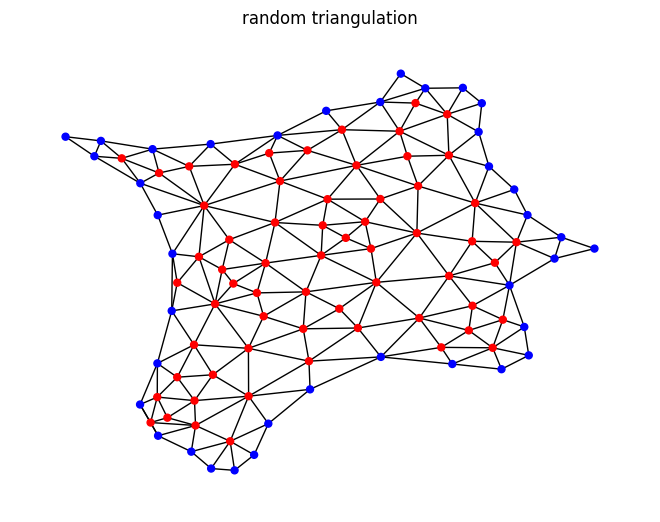

In [430]:
# spring layout for easier visual
pos=nx.spring_layout(delaunay_graph, iterations = 1000)
nx.draw(delaunay_graph, pos, node_size = 25, node_color = node_colors)
plt.title('random triangulation')

Get a test Zephyr embedding and draw it

In [417]:
from minorminer import find_embedding

condition_embed = True
k = 1
while condition_embed:
    embedding = find_embedding(delaunay_graph, target_graph, random_seed = k)
    k += 1
    max_chain_length = np.max([len(item) for item in embedding.values()])
    print('max chain length', max_chain_length)

    if max_chain_length < 3:
        print(k,'good embedding')
        condition_embed = False
    else:
        print(k, 'bad embedding')

G = dnx.zephyr_graph(4)
chain_colors = {}
for key in embedding.keys():
    if len(embedding[key]) == 1:
        chain_colors.update({key:'black'})
    else:
        chain_colors.update({key:'red'})

dnx.draw_zephyr_embedding(G, emb = embedding, embedded_graph = delaunay_graph, unused_color = 'none', chain_color = chain_colors, node_size = 4)

max chain length 3
2 bad embedding
max chain length 3
3 bad embedding
max chain length 3
4 bad embedding
max chain length 2
5 good embedding


Functions for full embedding and dictionaries

In [431]:
def enumerate_edges_in_common(nodes, embedding):
    edges = []
    for k1 in embedding[nodes[0]]:
        for k2 in embedding[nodes[1]]:
            edges.append((k1,k2))
    return edges

def Reverse(tup):
    newtup=(tup[1],tup[0])
    return newtup

def return_dicts(sampler, delaunay_graph, boundary_nodes, h_val, h_boundary, Jval, Kval):

    condition_embed = True
    k = 1
    while condition_embed:
        embedding = find_embedding(delaunay_graph, sampler.edgelist, random_seed = k)
        k += 1
        max_chain_length = np.max([len(item) for item in embedding.values()])
        print('max chain length', max_chain_length)

        if max_chain_length < 3:
            print(k,'good embedding')
            condition_embed = False
        else:
            print(k, 'bad embedding')

    h_dict = {}
    J_dict = {}

    for node in delaunay_graph.nodes():
        for emb in embedding[node]:
            if node in boundary_nodes:
                h_dict.update({emb:h_boundary/len(embedding[node])})
            else:
                h_dict.update({emb:h_val/len(embedding[node])})

    for edge in delaunay_graph.edges():
        # print(edge)
        test_edges = enumerate_edges_in_common(edge, embedding)
        # print(test_edges)
        filter_test_edges = []
        # print(test_edges)
        for ed in test_edges:
            if ed in sampler.edgelist:
                filter_test_edges.append(ed)
            elif Reverse(ed) in sampler.edgelist:
                filter_test_edges.append(ed)
        # print(filter_test_edges)
        for it in range(len(filter_test_edges)):
            J_dict.update({filter_test_edges[it]:Jval/len(filter_test_edges)})

    for local_embed in embedding.keys():
        if len(embedding[local_embed]) == 2:
            #print(tuple(embedding[local_embed]))
            J_dict.update({tuple(embedding[local_embed]):Kval})
    
    return h_dict, J_dict

In [432]:
h_val = 0.01
h_boundary = -0.2
Jval = -1
Kval = -2

h_dict, J_dict = return_dicts(sampler, delaunay_graph, boundary_nodes, h_val, h_boundary, Jval, Kval)

max chain length 3
2 bad embedding
max chain length 3
3 bad embedding
max chain length 4
4 bad embedding
max chain length 3
5 bad embedding
max chain length 2
6 good embedding


In [433]:
Nreads = 200
anneal_time = 100
response = sampler.sample_ising(h = h_dict, J=J_dict,
                                                num_reads=Nreads,
                                                annealing_time=anneal_time,
                                                answer_mode="raw")

In [434]:
dwave.inspector.show(response)

Serving Inspector on http://127.0.0.1:18000/?problemId=3df844cd-f1a5-43d0-bbd6-f8b47cdb8457

'http://127.0.0.1:18000/?problemId=3df844cd-f1a5-43d0-bbd6-f8b47cdb8457'

In [451]:
def magnetization_per_sample(resps, embedding, variables):
    mags = []
    # broken = []
    num_broken = []
    for k in range(len(resps)):
        ind_mag = 0
        ind_broken = 0
        for site in embedding.keys():
            # embedding[site][0]
            if len(embedding[site]) == 2:
                site1 = np.where(variables == embedding[site][0])[0][0]
                site2 = np.where(variables == embedding[site][1])[0][0]
                if resps[k][site1] == resps[k][site2]:
                    # broken.append('good')
                    ind_mag += resps[k][site1]
                else:
                    # broken.append('broken')
                    ind_broken += 1
                    ind_mag += 0
            else:
                print(embedding[site])
                site1 = np.where(variables == embedding[site][0])[0]
                print(site1)
                ind_mag += resps[k][site1]

        mags.append(ind_mag)
        num_broken.append(ind_broken)
    return mags, num_broken

def energy_per_sample(resps, embedding, variables, all_edges):

    ene = []
    for k in range(len(resps)):
        ind_ene = 0
        for edge in all_edges:
            if len(embedding[site]) == 2:
                site1 = np.where(variables == embedding[edge[0]][0])[0][0]
                site2 = np.where(variables == embedding[edge[1]][0])[0][0]
                ind_ene += resps[k][site1]*resps[k][site2]
            else:
                site1 = np.where(variables == embedding[edge[0]])[0][0]
                site2 = np.where(variables == embedding[edge[1]])[0][0]
                ind_ene += resps[k][site1]*resps[k][site2]
        ene.append(ind_ene)

    return ene

In [452]:
mags, numbroken = magnetization_per_sample(response.record.sample, embedding, np.array(response.variables))

print("avg mag_Z : ", np.mean(mags)/len(embedding))

energy = energy_per_sample(response.record.sample, embedding, np.array(response.variables), delaunay_graph.edges)

print('avg ene :', np.mean(energy)/len(delaunay_graph.edges))

[414]
[103]
[205]
[38]
[177]
[23]
[181]
[25]
[246]
[]


ValueError: non-broadcastable output operand with shape (1,) doesn't match the broadcast shape (0,)